## ADA Project Milestone 2: Initial data handling 

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

## Load datasets into pandas Dataframe
- _us_disaster_declarations_ is the additional dataset containing all natural disasters in the US from 1953 to 2021. <br>
- _natural_disaster_quotes_ dataset corresponds to the part of the Quotebank dataset that is useful for our project, i.e. it contains quotations citing the incident types. The type of incidents come from the incident_type column in the previous dataset. <br>
Note: We used the provided Google Colab notebook to generate the wanted compressed dataset.

In [2]:
# Load additional dataset

# Dataset: download at https://www.kaggle.com/headsortails/us-natural-disaster-declarations
# nd = natural disaters
nd_frame = pd.read_csv('data/us_disaster_declarations.csv')
print("Column names and their data types (more info here: \
https://www.kaggle.com/headsortails/us-natural-disaster-declarations )\n")
print(nd_frame.dtypes)

Column names and their data types (more info here: https://www.kaggle.com/headsortails/us-natural-disaster-declarations )

fema_declaration_string       object
disaster_number                int64
state                         object
declaration_type              object
declaration_date              object
fy_declared                    int64
incident_type                 object
declaration_title             object
ih_program_declared            int64
ia_program_declared            int64
pa_program_declared            int64
hm_program_declared            int64
incident_begin_date           object
incident_end_date             object
disaster_closeout_date        object
fips                           int64
place_code                     int64
designated_area               object
declaration_request_number     int64
hash                          object
last_refresh                  object
id                            object
dtype: object


In [3]:
# Not all are "natural" disasters
nd_types = nd_frame.incident_type.unique()
print(nd_types)

['Tornado' 'Flood' 'Fire' 'Other' 'Earthquake' 'Hurricane' 'Volcano'
 'Severe Storm(s)' 'Toxic Substances' 'Typhoon' 'Drought'
 'Dam/Levee Break' 'Snow' 'Severe Ice Storm' 'Freezing' 'Coastal Storm'
 'Fishing Losses' 'Mud/Landslide' 'Human Cause' 'Terrorist' 'Tsunami'
 'Chemical' 'Biological']


This is the dictionary we use to extract relevant quotations from the Quotebank dataset. As we can see, some of them are similar (multiple kinds of storms), and others are not "natural" disasters (Human Cause, Terrorist, ...). Some modifications are done, for instance we must also add lowercase version of the terms, and we will also ignore some types of incidents in further analysis, e.g. Fire, Snow, ..., since they are hard to work with for what we want to accomplish. As we will see, some of these terms are used in other contexts that may be irrelevant. 

In [4]:
# Load quotation dataset

df_quotes = pd.read_json('data/natural_disaster_quotes.json.bz2', lines=True, compression='bz2')
print(f"Number of quotes: %d" % len(df_quotes.index))

Number of quotes: 1480711


In [5]:
print("Column names and their data types\n")
print(df_quotes.dtypes)

Column names and their data types

quoteID                   object
quotation                 object
speaker                   object
qids                      object
date              datetime64[ns]
numOccurrences             int64
probas                    object
urls                      object
phase                     object
dtype: object


In [6]:
df_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-13-009373,But he said `you're responsible. You make peop...,Tom Elliott,"[Q16196918, Q21461424, Q7815715, Q8952291]",2020-01-13 05:00:53,1,"[[Tom Elliott, 0.5795], [None, 0.4205]]",[https://www.3aw.com.au/tom-elliott-calls-for-...,E
1,2020-03-11-014404,Everything that went wrong was always my fault...,Kate James,[Q56379605],2020-03-11 13:04:58,2,"[[Kate James, 0.8144], [None, 0.1397], [Amber ...",[https://calgarysun.com/entertainment/celebrit...,E
2,2020-04-10-011917,"Great guy, messiest desk I ever saw, like a to...",None,[],2020-04-10 04:00:00,3,"[[None, 0.7283], [Brad Harris, 0.2717]]",[http://newstimes.com/news/coronavirus/article...,E
3,2020-01-18-012600,How will they attend to the problems of the pe...,Krishna Byre Gowda,[Q6437387],2020-01-18 18:13:36,1,"[[Krishna Byre Gowda, 0.89], [None, 0.11]]",[https://www.thehindu.com/news/national/karnat...,E
4,2020-02-21-031866,I'm sure you hear it every day but you are smo...,None,[],2020-02-21 21:12:31,1,"[[None, 0.9031], [Donatella Versace, 0.0969]]",[http://feeds.inquisitr.com/~r/google/yDYq/~3/...,E


In [7]:
pd.options.display.max_colwidth = 200 # this is to see most of the text of the quotations
df_quotes.head().quotation
# Lots of irrelevant quotes! -> DISCUSS

0                                                                                                                          But he said `you're responsible. You make people think the wrong way about fires.
1    Everything that went wrong was always my fault. I remember one occasion where she missed a connection on a flight on or around Christmas Day in 2012. My aunt was visiting from Australia at that ti...
2    Great guy, messiest desk I ever saw, like a tornado hit a landfill but he knew where everything was! Funniest thing was the time the overnight cleaning crew left a full black garbage bag on his ch...
3        How will they attend to the problems of the people without a full-fledged Ministry? You are not able to provide a Minister in charge of the districts. You are unable to take up flood relief work,
4                                                                                                                           I'm sure you hear it every day but you are smoking hot c

Text(0, 0.5, 'Frequency')

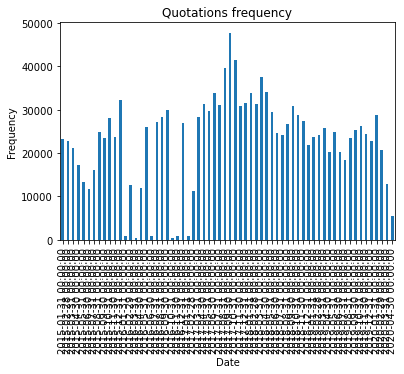

In [8]:
# Frequency histogram of the quotes w.r.t. dates
# add column with ones to groupby and count number of quotes in a month (for example)
df_quotes['count'] = 1

df_tmp = df_quotes.groupby(pd.Grouper(key='date', axis=0, freq='M')).sum()
# TODO: make pretty :)
df_tmp['count'].plot(kind='bar')
plt.title("Quotations frequency")
plt.xlabel("Date")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

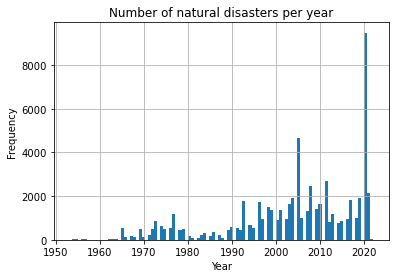

In [9]:
# Natural disasters per year
nd_frame['fy_declared'].hist(bins=100)
plt.title("Number of natural disasters per year")
plt.xlabel("Year")
plt.ylabel("Frequency")

# 2020 because of Covid-19 ? -> TODO: remove rows after April 2020 (don't have quotes for it) 
# Remove "Biological" disasters ????

In the graph above, we easily observe that a large number of crisis that happend in 2020. With further investigation of the natural disaster dataset, we see that this mainly represents "Biological" disasters (see following plots), most notably Covid-19. We decided to ignore these types of incident going further, since it is a worldwide pandemic and does not have a fixed time period.

In [10]:
# get data rows from 2015 to 2020 and drop irrelevant rows
nd_frame.drop(nd_frame[nd_frame['fy_declared'] < 2015].index, inplace = True)
nd_frame.drop(nd_frame[nd_frame['fy_declared'] > 2020].index, inplace = True)

nd_frame.drop(nd_frame[nd_frame.incident_type == "Other"].index, inplace = True)
print(nd_frame.head().iloc[:, :7])

      fema_declaration_string  disaster_number state declaration_type  \
44317              DR-4197-NM             4197    NM               DR   
44318              DR-4197-NM             4197    NM               DR   
44319              DR-4197-NM             4197    NM               DR   
44320              DR-4197-NM             4197    NM               DR   
44321              DR-4197-NM             4197    NM               DR   

           declaration_date  fy_declared    incident_type  
44317  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44318  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44319  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44320  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44321  2014-10-06T19:20:00Z         2015  Severe Storm(s)  


Text(0, 0.5, 'Frequency')

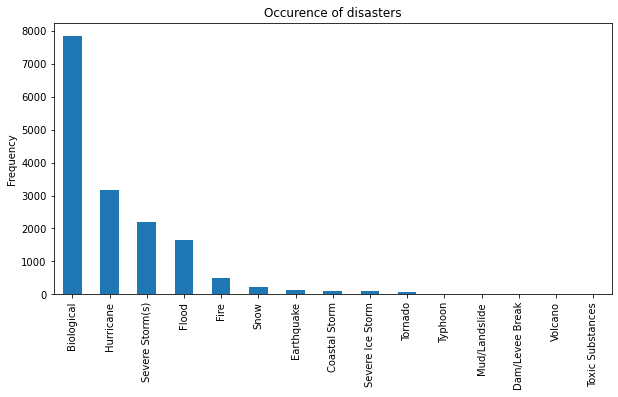

In [11]:
# Occurence of different disasters
nd_frame['incident_type'].value_counts().plot(kind='bar', figsize=(10, 5), title="Occurence of disasters")
plt.ylabel("Frequency")

In [12]:
# CAN DO MORE BASIC STATISTICS MAYBE ?
print(f"Number of natural disasters from 2015 to 2020: %d" % len(nd_frame.index))

Number of natural disasters from 2015 to 2020: 16068


In [13]:
#TODO: Data handling and analysis -> ADD SOME EXPLANATIONS FOR GRAPHS
#print(nd_frame['incident_type'].value_counts())

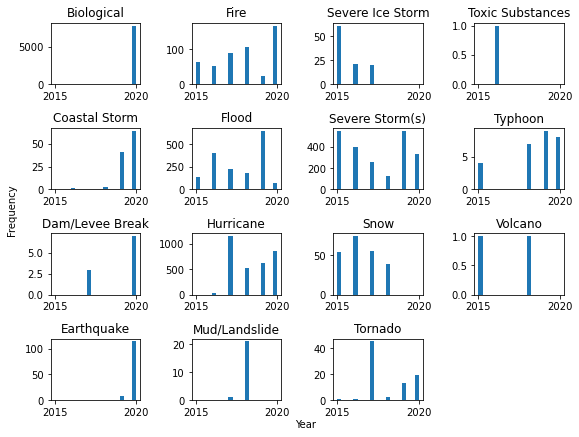

In [14]:
# "Ground truth" plots

stats_by_type = nd_frame.groupby('incident_type').apply(lambda x: pd.Series({
        'fy_declared': x['fy_declared'].values
    }))

fig, ax = plt.subplots(4, 4, figsize=(8,6), sharey=False, sharex=False)

for i in range(15):
    sbplt = ax[i%4, math.floor(i/4)]
    sbplt.hist(stats_by_type.iloc[i].values, range=[2015,2020], bins = 20)
    sbplt.set_title(stats_by_type.index[i])
    
fig.tight_layout()

fig.text(0.5,0, "Year")
fig.text(0,0.45, "Frequency", rotation = 90)
fig.delaxes(ax[3][3])
#fig.suptitle("Ground truth for natural disasters")

# MAYBE BIGGER AND MORE CLEAR IF POSSIBLE !!!!
# !!!!!! y-axis not the same (intended)
# CHECK WEIRD VALUES (EARTHQUAKES.....)

These are the occurences of the disasters that really happend. As previously said, we see most notably that "Biological" incident happend almost only in 2020. We will now see if it is possible to observe the catastrophies only from the quotations.

In [15]:
# Separate quotes in different dataframes with respect to the type of disaster

#['Severe Storm(s)', 'Fire', 'Volcano', 'Flood', 'Tornado',
# 'Severe Ice Storm', 'Typhoon', 'Coastal Storm' ,
# 'Hurricane', 'Landslide', 'Dam/Levee Break', 'Earthquake']
def get_occurrence(df, string):
    low_str = string.lower()
    return df[df['quotation'].apply(lambda s: s.lower()).str.contains(low_str)]

df_hurricane = get_occurrence(df_quotes, "hurricane")
df_typhoon = get_occurrence(df_quotes, "typhoon")
df_tornado = get_occurrence(df_quotes, "tornado")
df_flood = get_occurrence(df_quotes, "flood")
# can be more precise, need to explore further
df_storm = get_occurrence(df_quotes, "storm")
df_volcano = get_occurrence(df_quotes, "volcano")
# !!! Fire pretty general term -> discuss that there are a lot of irrelevant quotes
df_fire = get_occurrence(df_quotes, "fire")
df_landslide = get_occurrence(df_quotes, "landslide")
df_earthquake = get_occurrence(df_quotes, "earthquake")
df_dam = get_occurrence(df_quotes, "dam")

In [16]:
# Basic statistics per incident type
print(f"Number of quotes for Hurricanes: %d" % len(df_hurricane.index))
print(f"Number of quotes for Typhoons: %d" % len(df_typhoon.index))
print(f"Number of quotes for Tornados: %d" % len(df_tornado.index))
print(f"Number of quotes for Floods: %d" % len(df_flood.index))
print(f"Number of quotes for Storms: %d" % len(df_storm.index))
print(f"Number of quotes for Volcanos: %d" % len(df_volcano.index))
print(f"Number of quotes for Fires: %d" % len(df_fire.index))
print(f"Number of quotes for Landslides: %d" % len(df_landslide.index))
print(f"Number of quotes for Earthquakes: %d" % len(df_earthquake.index))
print(f"Number of quotes for Dam breaks: %d" % len(df_dam.index))

Number of quotes for Hurricanes: 57043
Number of quotes for Typhoons: 3827
Number of quotes for Tornados: 12096
Number of quotes for Floods: 118441
Number of quotes for Storms: 153573
Number of quotes for Volcanos: 6277
Number of quotes for Fires: 692022
Number of quotes for Landslides: 7748
Number of quotes for Earthquakes: 24523
Number of quotes for Dam breaks: 34599


Text(0, 0.5, 'Frequency')

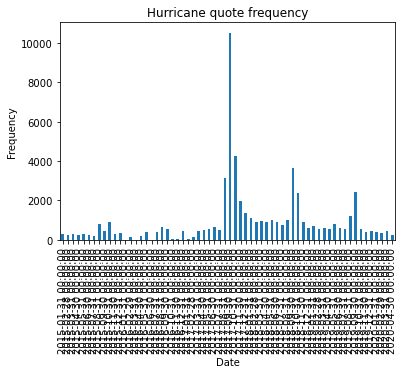

In [17]:
# Plots w.r.t. dates

# 'M' means MONTHS, can group by other value if needed
df_hurr = df_hurricane.groupby(pd.Grouper(key='date', axis=0, freq='M')).sum()
df_hurr['count'].plot(kind='bar')
plt.title("Hurricane quote frequency")
plt.xlabel("Date")
plt.ylabel("Frequency")
# Need to see correlation with ground truth

# TODO: other plots for incident types + make pretty (maybe not bar plot), BUT NEED UPGRADED QUOTE DATASET ...

In [18]:
places = np.array(["Montgomery", "Alabama", "Juneau", "Alaska", "Phoenix", "Arizona", "Little Rock", "Arkansas",
                  "Sacramento", "California", "Denver", "Colorado", "Hartford", "Connecticut", "Dover", "Delaware",
                  "Tallahassee", "Florida", "Atlanta", "Georgia", "Honolulu", "Hawaii", "Boise", "Idaho",
                  "Springfield", "Illinois", "Indianapolis", "Indiana", "Des Moines", "Iowa", "Topeka", "Kansas",
                  "Frankfort", "Kentucky", "Baton Rouge", "Louisiana", "Augusta", "Maine", "Annapolis", "Maryland", 
                  "Boston", "Massachusetts", "Lansing", "Michigan", "St. Paul", "Minnesota", "Jackson", "Mississippi",
                  "Jefferson City", "Missouri", "Helena", "Montana", "Lincoln", "Nebraska", "Carson City", "Nevada",
                  "Concord", "New Hampshire", "Trenton", "New Jersey", "Santa Fe", "New Mexico",
                  "Albany", "New York", "Raleigh", "North Carolina", "Bismarck", "North Dakota", "Columbus", "Ohio",
                  "Oklahoma City", "Oklahoma", "Salem", "Oregon", "Harrisburg", "Pennsylvania", "Providence", "Rhode Island", 
                  "Columbia", "South Carolina", "Pierre", "South Dakota", "Nashville", "Tennessee", "Austin", "Texas", 
                  "Salt Lake City", "Utah", "Montpelier", "Vermont", "Richmond", "Virginia", "Olympia", "Washington",
                  "Charleston", "West Virginia", "Madison", "Wisconsin", "Cheyenne", "Wyoming"])
print(len(places))
pattern = '|'.join(places)
#print(pattern)

100


In [19]:
df_loc = df_hurricane[df_hurricane['quotation'].str.contains(pattern)]

In [20]:
df_loc.head(10).quotation

517                 It's like we have 54 separate hurricanes in every state and territory and the District of Columbia... Unlike a hurricane, we don't know when this is going to dissipate or move out to sea,
2038                  I thank FEMA for their continued commitment to our Florida communities in their recovery from Hurricane Irma. The reimbursement announced last night for St. John's County is great news,
2747                                             We did a study a few years ago that showed Hurricane Harvey in Texas passed over a very warm body of water, and that greatly increased the amount of rainfall.
2793                                          Every hurricane season, we have lots of questions come in and in the event that something does happen in Central Florida, we're able to update that in real-time,
3044    Backstory: During Hurricane Harvey, the MuttNation Team went to Houston to help relocate existing shelter dogs to free up shelter space for animals separated by

In [21]:
print(f"Number of quotations containing hurricane + state|city: %d" % len(df_loc.index))

Number of quotations containing hurricane + state|city: 9036


In [32]:
place_occurrence = [len(df_hurricane[df_hurricane["quotation"].str.contains(place)].index) for place in places]

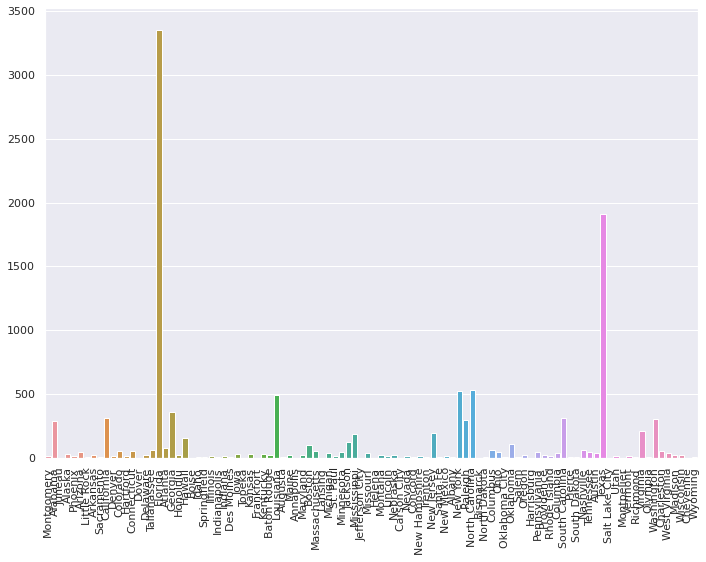

In [33]:
sns.barplot(x=places, y=place_occurrence)
plt.xticks(rotation=90)
sns.set(rc={'figure.figsize':(18.7,14.27)})

In [41]:
# Count if there are some speakers that occur more often
speaker_count = df_loc["speaker"].value_counts()
speaker_count.head(20)

None                      3042
Gov. Rick Scott            205
President Donald Trump     130
Roy Cooper                 121
Greg Abbott                115
Ron DeSantis                80
Governor Rick Scott         77
Marco Rubio                 69
Henry McMaster              63
President Trump             62
Bill Nelson                 58
Adam Putnam                 42
Jimmy Patronis              40
Rick Scott                  39
Andrew Cuomo                31
Brock Long                  31
Gov. John Bel Edwards       30
Ralph Northam               28
Ted Cruz                    28
Gov. Nathan Deal            27
Name: speaker, dtype: int64